# CartPole with Actor-Critic(A2C)
---

In [1]:
import os
try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
import gym

import numpy as np
import pandas as pd
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append('../material')
from utils import moving_average
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from IPython.display import Video

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
env = gym.make('CartPole-v1')
#env._max_episode_steps=2000

xcb_connection_has_error() returned true
xcb_connection_has_error() returned true


(-0.5, 599.5, 399.5, -0.5)

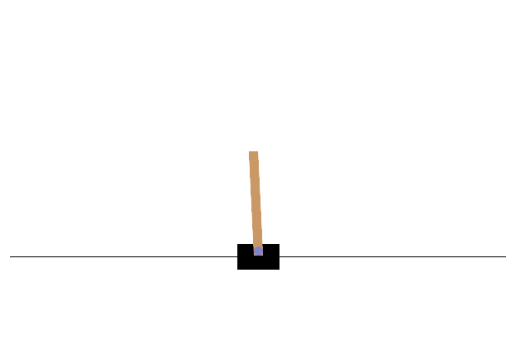

In [6]:
env.reset()
plt.imshow(env.render('rgb_array'))
plt.axis('off')

## 방법1. 단순 State

In [7]:
class A2C_Agent(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(A2C_Agent,self).__init__()
        '''
        입력변수
            state_shape: state 차원 -> [위치, 속도, 각도, 각속도]
            output_dim: actor 차원 -> [왼쪽, 오른쪽]
                        critic 차원 -> 1
            device : cpu, cuda device정보 
        N.N 구조
            2 - hidden layers, 64 nodes
            Activation function -> Relu
        '''
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.seq = nn.Sequential(
            nn.Linear(self.state_shape,128), 
            nn.ReLU(),
        )
        self.policy = nn.Sequential(
            nn.Linear(128,self.n_actions)
        )
            
        self.value = nn.Sequential(
            nn.Linear(128,1)
        )
        
    def forward(self, state_t):
        '''
        입력인자
            state_t : 상태([batch,state_shape]), torch.tensor
        출력인자
            policy : 정책([batch,n_actions]), torch.tensor
            value : 가치함수([batch]), torch.tensor
        '''
        policy = self.policy(self.seq(state_t))
        value = self.value(self.seq(state_t)).squeeze(dim=-1)
        return policy, value

    def sample_actions(self,state_t):
        '''
        입력인자
            state_t : 상태([1,state_shape]), torch.tensor
        출력인자
            action_t : 행동함수 using torch.multinomial
        '''
        policy, _ = self.forward(state_t)
        policy = torch.squeeze(policy)
        softmax_policy = F.softmax(policy,dim=0)
        action = torch.multinomial(softmax_policy, num_samples=1).item()
        return action

In [8]:
# 하이퍼 파라미터 정의
env = gym.make('CartPole-v0')
env.seed(123)
#env._max_episode_steps=2000

gamma=0.99
epsilon = 1e-03

state = env.reset()
num_state = state.shape[0]
num_action = env.action_space.n
learning_rate = 5e-04
max_episode = 1000

/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [9]:
train_agent = A2C_Agent(num_state,num_action).to(device)
optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.97)

In [10]:
def A2C_loss(transition,train_agent,env,gamma=gamma):
    '''
    A2C loss함수 계산코드
    입력인자
        batch_sample - 리플레이로부터 받은 샘플(S,A,R,S',done)
        train_agent - 훈련에이전트
        env - 환경
        gamma - 할인율
    출력인자
        Total_loss
    목적함수 
        -log(policy)*advantage + (value_infer-value_target)**2 + policy*log(policy)
        Actor-loss(exploitation): "log(policy)*advantage"
        Actor-entropy(exploration): "policy*log(policy)"
        Critic-loss: "MSE(value_infer - value_target)"
    '''
    states,actions,rewards,next_state,done = transition
    
    states = torch.Tensor(states).to(device).view(-1,num_state)
    #actions = torch.Tensor(actions).to(device).view(-1,num_action)
    rewards = torch.Tensor(rewards[None]).to(device)
    next_state = torch.Tensor([next_state]).to(device).view(-1,num_state)
    
    policies, values = train_agent(states)
    _, next_value = train_agent(next_state)
    if done:
        next_value = 0
    
    probs = F.softmax(policies,dim=-1)
    logprobs = F.log_softmax(policies,dim=-1)

    target_values = rewards+gamma*next_value
    
    advantages = target_values - values
    entropy = -torch.sum(probs*logprobs,dim=-1)

    actor_loss = -torch.mean(logprobs*advantages.detach() + epsilon*entropy)
    critic_loss = F.mse_loss(target_values.detach(),values)
    total_loss = actor_loss + critic_loss
    return total_loss, actor_loss, critic_loss

310번째 에피소드 결과
최근 10 에피소드 보상평균 = 183.2
최근 10 에피소드 A2C오차 = 18.03324021770307


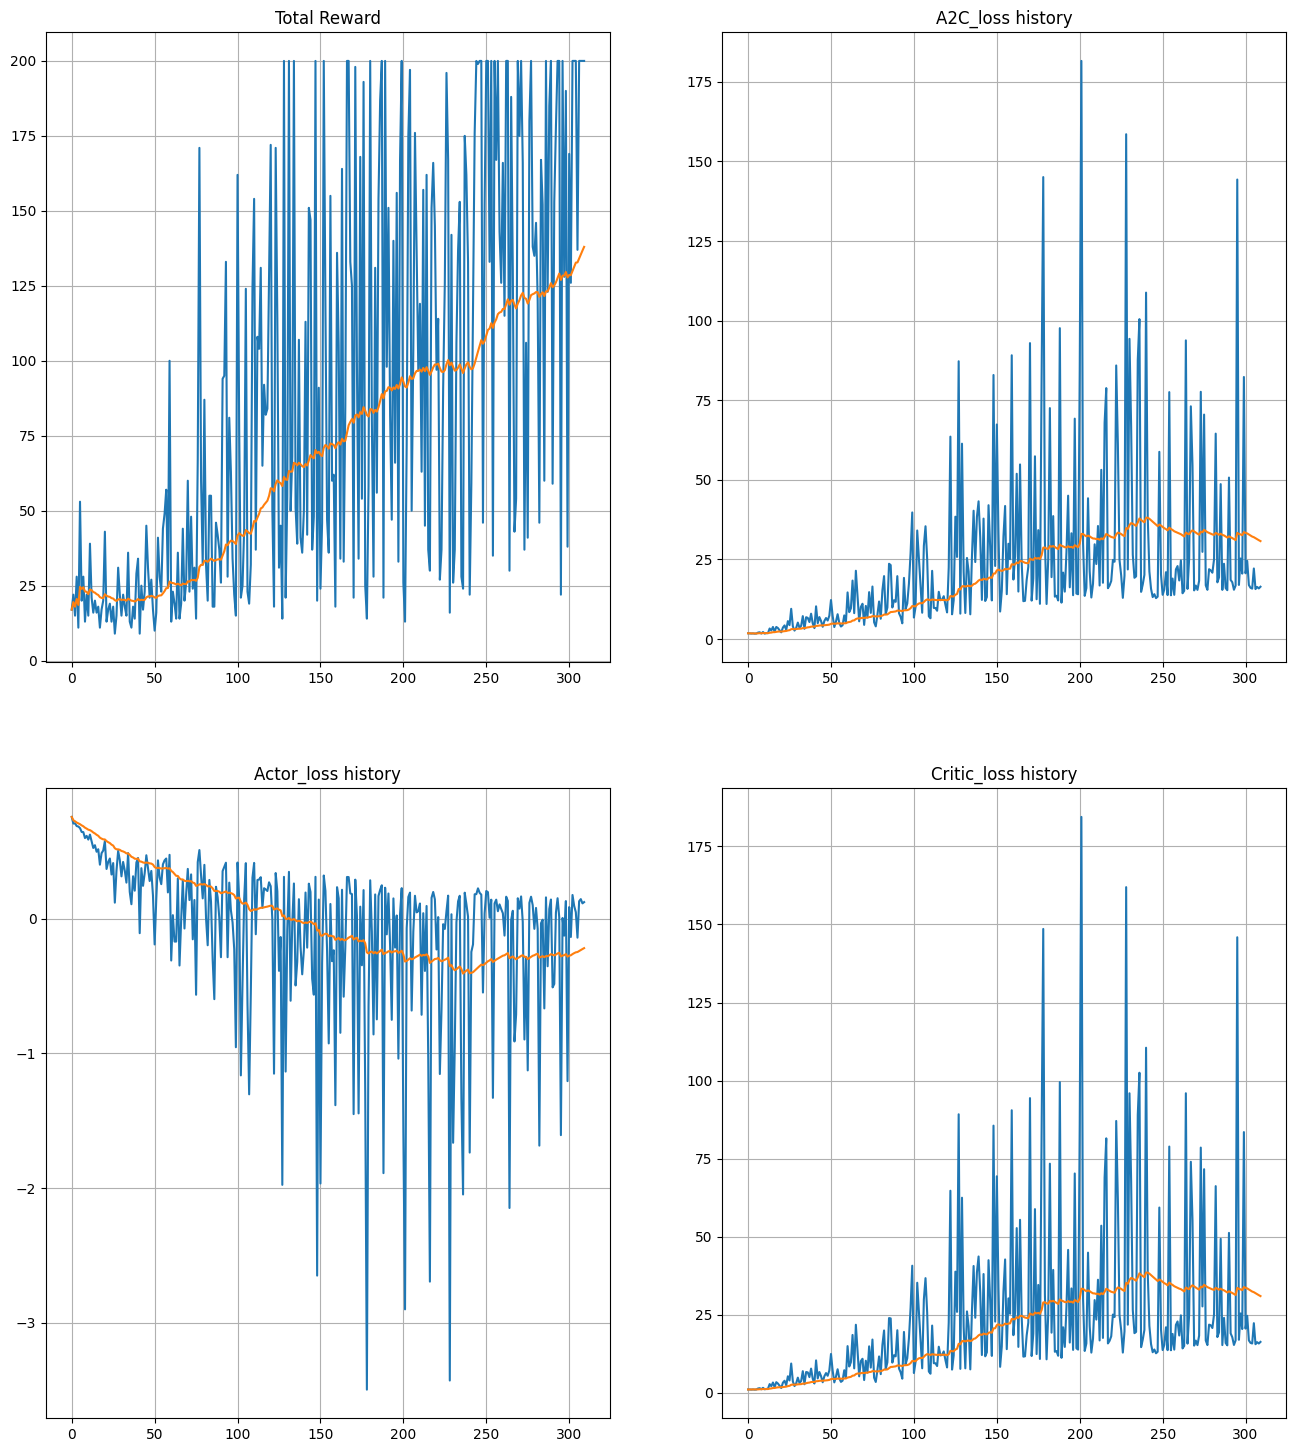

충분한 보상: 183.2
학습종료


In [11]:
reward_record, TDloss_record, ACloss_record, CRloss_record = [], [], [], []
for ep in range(max_episode):
    done = False
    state = env.reset()
    cnt = 0
    total_reward = 0
    total_episode_TD = 0
    total_episode_acloss = 0
    total_episode_crloss = 0
    

    while True:
        torch_state = torch.Tensor(state).to(device)
        torch_state = torch.unsqueeze(torch_state,0)
        action = train_agent.sample_actions(torch_state)
        next_state,reward,done,_ = env.step(action)
        total_reward += reward
        
        transition = (state,action,np.array([reward]),next_state,done)
        loss,actor_loss,critic_loss = A2C_loss(transition,train_agent,env,gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_episode_TD += loss.item()
        total_episode_acloss += actor_loss.item()
        total_episode_crloss += critic_loss.item()

        if done:
            ep +=1 
            #mean_episode_TD /= cnt    
            TDloss_record.append(total_episode_TD/cnt)
            ACloss_record.append(total_episode_acloss/cnt)
            CRloss_record.append(total_episode_crloss/cnt)
            reward_record.append(total_reward)
            if total_reward == env._max_episode_steps:
                best_agent = copy.deepcopy(train_agent)
            break
        
        # 업데이트
        state = next_state
        cnt += 1
    #scheduler.step()
    
    if ep % 10 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'최근 10 에피소드 보상평균 = {np.mean(reward_record[-10:])}')
        print(f'최근 10 에피소드 A2C오차 = {np.mean(TDloss_record[-10:])}')
        
        plt.figure(figsize=[16, 18])
        
        plt.subplot(2,2,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()
        
        plt.subplot(2,2,2)
        plt.title("A2C_loss history")
        plt.plot(TDloss_record)
        plt.plot(moving_average(TDloss_record))
        plt.grid()
    
        
        plt.subplot(2,2,3)
        plt.title("Actor_loss history")
        plt.plot(ACloss_record)
        plt.plot(moving_average(ACloss_record))
        plt.grid()
        
        plt.subplot(2,2,4)
        plt.title("Critic_loss history")
        plt.plot(CRloss_record)
        plt.plot(moving_average(CRloss_record))
        plt.grid()
    
        plt.show()
    
    if np.mean(reward_record[-10:]) >= 180:
        print(f"충분한 보상: {np.mean(reward_record[-10:])}")
        print(f"학습종료")
        break

In [12]:
torch.save(best_agent,'./ckpt/CartPole/A2C_bestagent.pth')
agent = torch.load('./ckpt/CartPole/A2C_bestagent.pth')

In [19]:
import gym.wrappers

def record(initial_state,agent,env,vid):
    state = initial_state
    sum_rewards = 0

    while True:
        vid.capture_frame()
        torch_state = torch.Tensor(state).to(device)
        torch_state = torch.unsqueeze(torch_state,0)
        action = agent.sample_actions(torch_state)

        next_state,reward,done,_ = env.step(action)
        
        state = next_state
        sum_rewards += reward
        if done:
            break
    vid.close()
    return sum_rewards

env = gym.make('CartPole-v0')
env._max_episode_steps=600
env.seed(123)
vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,path='./videos/CartPole/CartPole_video.mp4')
vid.render_mode="rgb_array"
#while True:
#    state = env.reset()
#    rewards = record(state,train_agent,env,vid)
#    if rewards >= 600:
#        break
#print(rewards)
state = env.reset()
rewards = record(state,train_agent,env,vid)
print(rewards)

288.0


In [20]:
Video('./videos/CartPole/CartPole_video.mp4',embed=True,width=512, height=512)